<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/DeHazenet/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import tensorflow_addons as tfa

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing and loading of data

In [ ]:
#ls drive/MyDrive/reside/archive/clear_images drive/MyDrive/reside/archive/haze  

In [2]:
# function to load the image in the form of tensors.

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (413, 550), antialias = True)
    img = img / 255.0
    return img

In [3]:
# function to get the path of individual image.
'''
def data_path(orig_img_path, hazy_img_path):
    
    train_img = []
    val_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[:int(0.9*n)]        #90% data for train, 10% for test
    val_keys = orig_img[int(0.9*n):]
    
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = img.split('/')[-1]
        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'
        if (split_dict[orig_path] == 'train'):
            train_img.append([img, orig_path])
        else:
            val_img.append([img, orig_path])
            
    return train_img, val_img
    '''

"\ndef data_path(orig_img_path, hazy_img_path):\n    \n    train_img = []\n    val_img = []\n    \n    orig_img = glob.glob(orig_img_path + '/*.jpg')\n    n = len(orig_img)\n    random.shuffle(orig_img)\n    train_keys = orig_img[:int(0.9*n)]        #90% data for train, 10% for test\n    val_keys = orig_img[int(0.9*n):]\n    \n    split_dict = {}\n    for key in train_keys:\n        split_dict[key] = 'train'\n    for key in val_keys:\n        split_dict[key] = 'val'\n        \n    hazy_img = glob.glob(hazy_img_path + '/*.jpg')\n    for img in hazy_img:\n        img_name = img.split('/')[-1]\n        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'\n        if (split_dict[orig_path] == 'train'):\n            train_img.append([img, orig_path])\n        else:\n            val_img.append([img, orig_path])\n            \n    return train_img, val_img\n    "

In [4]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.10,validation_size=64,test_size=64,seed_val=200):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b



In [5]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [6]:
# function to display output.

def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i])
        
    plt.show()

# Network Function

In [69]:
#def dehaze_net():
class dehaze_net(tf.keras.Model):
  def __init__(self):
    super(dehaze_net,self).__init__()
    self.conv1 = Conv2D(input_shape = (413, 550, 3), filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    self.conv2 = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', use_bias = True)
    self.conv3 = Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    self.conv4 = Conv2D(filters = 16, kernel_size = 7, strides = 1, padding = 'same', use_bias = True)
    self.maxpool=MaxPool2D(7)
    self.conv5 = Conv2D(filters = 1, kernel_size = 6, strides = 1, padding = 'same', use_bias = True)
    self.Maxout=tfa.layers.Maxout(num_units=4,axis= -1)


  def call(self,x):
    out = self.conv1(x)
    out = self.Maxout(out)
    return out

   #K = conv5
   #output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
   #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
   #output=tf.image.resize(output1, size = (413, 550), antialias = True)
   #model = Model(inputs = x, outputs = output)
   
   #return output

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))



Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 412, 548, 3)]     0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 412, 548, 16)      1216      
_________________________________________________________________
maxout_2 (Maxout)            (None, 412, 548, 4)       0         
Total params: 1,216
Trainable params: 1,216
Non-trainable params: 0
_________________________________________________________________


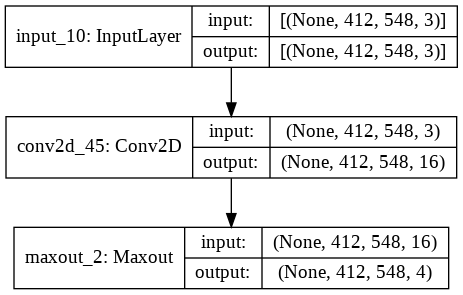

In [70]:
model=dehaze_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [54]:
model.trainable_variables

[]

In [ ]:
# Hyperparameters
epochs = 10
batch_size = 8
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train_data, val_data = data_path(orig_img_path = '/content/drive/MyDrive/dataset/clear_images', hazy_img_path = '/content/drive/MyDrive/dataset/haze')
#train_data, val_data = data_path()
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
#net =dehaze_net()

net= tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

1116


In [ ]:
def custom_loss(orig,pred):
  a=tf.keras.losses.MAE(orig,pred)
  a=tf.math.reduce_mean(a,axis=None)
  b=tf.image.ssim_multiscale(orig,pred,max_val=1)
  b=tf.math.reduce_mean(b,axis=None)
  #print(a.shape)
  #print(b.shape)
  alpha=0.025
  #a=0
  #alpha=1
  return alpha*b+(1-alpha)*a

In [ ]:



def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #loss = mean_squared_error(train_batch_orig, train_logits)
                #loss=tf.math.reduce_mean(loss,axis=None)
                #er=tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.AUTO)
                #loss=er(train_batch_orig, train_logits)/batch_size
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                #loss=tf.image.ssim(train_batch_orig, train_logits, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
                loss=custom_loss(train_batch_orig, train_logits)
                #loss=tf.math.reduce_mean(loss)
                #print(loss)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [===]  -  Training Loss: 0.0099

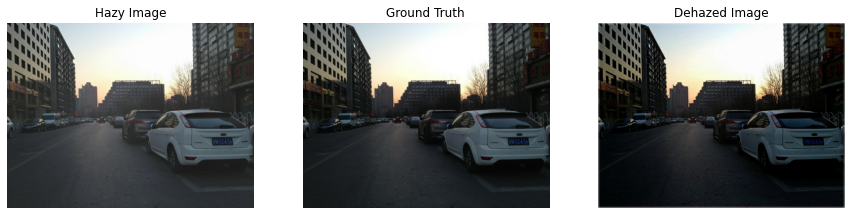

  -  Validation Loss: 0.0111  -   Time taken: 470.11s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 1 [===]  -  Training Loss: 0.0098

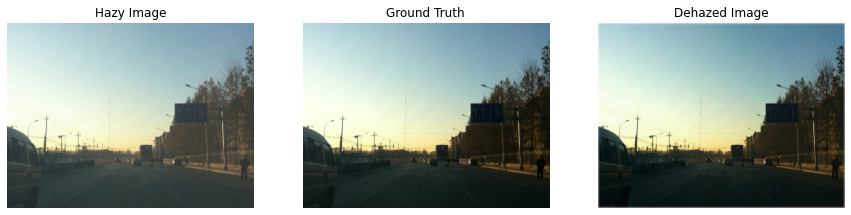

  -  Validation Loss: 0.0112  -   Time taken: 114.27s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 2 [===]  -  Training Loss: 0.0098

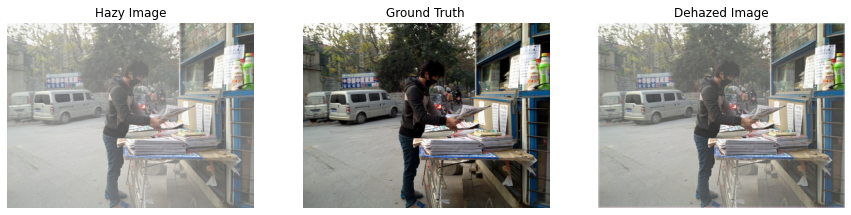

  -  Validation Loss: 0.0107  -   Time taken: 114.31s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 3 [===]  -  Training Loss: 0.0098

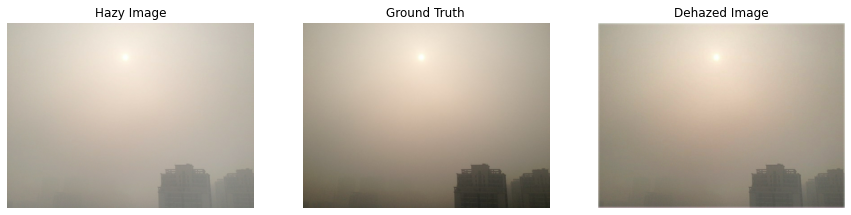

  -  Validation Loss: 0.0105  -   Time taken: 114.58s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 4 [===]  -  Training Loss: 0.0098

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


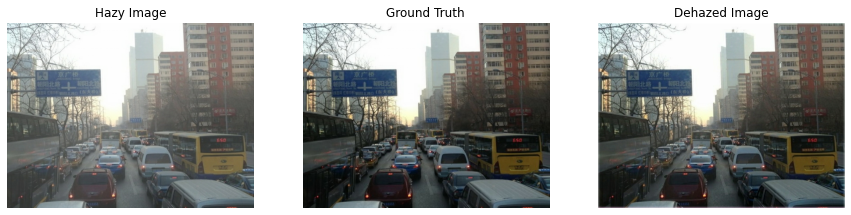

  -  Validation Loss: 0.0105  -   Time taken: 114.71s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 5 [===]  -  Training Loss: 0.0098

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


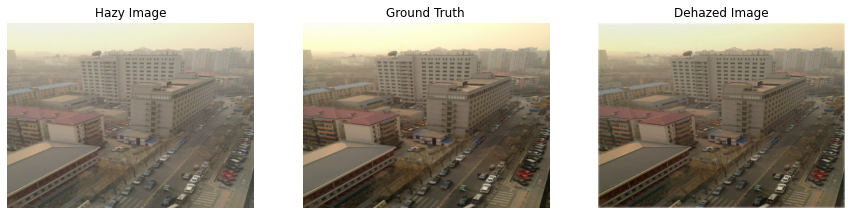

  -  Validation Loss: 0.0114  -   Time taken: 114.61s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 6 [===]  -  Training Loss: 0.0098

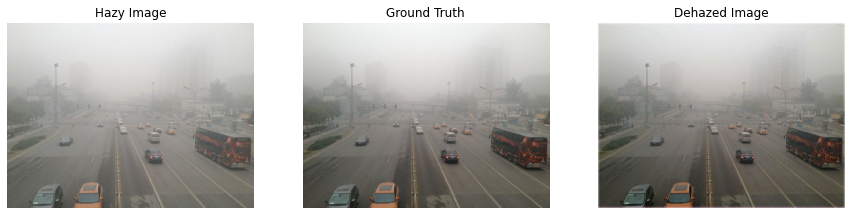

  -  Validation Loss: 0.0106  -   Time taken: 114.78s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 7 [===]  -  Training Loss: 0.0099

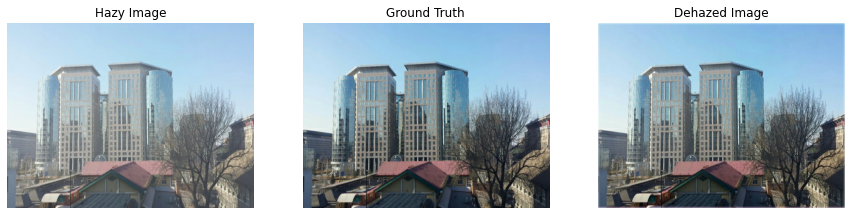

  -  Validation Loss: 0.0102  -   Time taken: 115.07s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 8 [===]  -  Training Loss: 0.0098

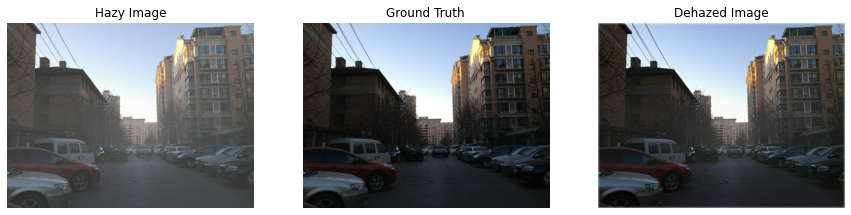

  -  Validation Loss: 0.0105  -   Time taken: 114.51s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 9 [===]  -  Training Loss: 0.0099

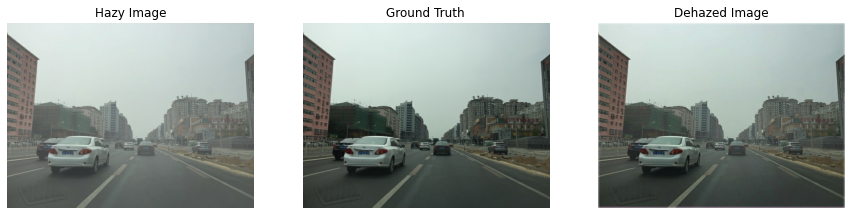

  -  Validation Loss: 0.0116  -   Time taken: 114.60s
INFO:tensorflow:Assets written to: trained_model/assets
CPU times: user 6min 32s, sys: 35.4 s, total: 7min 7s
Wall time: 25min 11s


In [ ]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)

In [ ]:
net.save('/content/drive/MyDrive/nets/dehazenet')
#model=net
#model.build([512,512,3])
#model.summary()

INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/dehazenet/assets


In [ ]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/Final_compare/HAZY/*.jpg')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        img = tf.image.resize(img, size = (413,550), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        directory = '/content/drive/MyDrive/Final_compare/dehazenet'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, im)

        os.chdir('/content')
        i+=1;
        

In [ ]:

new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet/trained_model',compile=False)

evaluate_gen(new_model)



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 

In [ ]:
cp -r trained_model/ /content/drive/MyDrive/nets/dehazenet/trained_model

In [13]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from PIL import Image
import torchvision
from torchvision import transforms
import torch.utils.data as data
#import torchsnooper
import cv2

In [45]:
class BRelu(nn.Hardtanh):
	def __init__(self, inplace=False):
		super(BRelu, self).__init__(0., 1., inplace)
		
	def extra_repr(self):
		inplace_str = 'inplace=True' if self.inplace else ''
		return inplace_str

class DehazeNet(nn.Module):
	def __init__(self, input=16, groups=4):
		super(DehazeNet, self).__init__()
		self.input = input
		self.groups = groups
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.input, kernel_size=5,padding=2)
		self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5, padding=2)
		self.conv4 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=7, padding=3)
		self.maxpool = nn.MaxPool2d(kernel_size=7, stride=1,padding=3)
		self.conv5 = nn.Conv2d(in_channels=48, out_channels=1, kernel_size=6,padding=3)
		#self.brelu = nn.BReLU()
		for name, m in self.named_modules():
			# lambda : 定义简单的函数    lambda x: 表达式
			# map(func, iter)  iter 依次调用 func
			# any : 有一个是true就返回true
			if isinstance(m, nn.Conv2d):
				# 初始化 weight 和 bias
				nn.init.normal(m.weight, mean=0,std=0.001)
				if m.bias is not None:
					nn.init.constant_(m.bias, 0)
	
	def Maxout(self, x, groups):
		x = x.reshape(x.shape[0], groups, x.shape[1]//groups, x.shape[2], x.shape[3])
		x, y = torch.max(x, dim=2, keepdim=True)
		out = x.reshape(x.shape[0],-1, x.shape[3], x.shape[4])
		return out
	#BRelu used to CPU. It can't work on GPU.
	def BRelu(self, x):
		x = torch.max(x, torch.zeros(x.shape[0],x.shape[1],x.shape[2],x.shape[3]))
		x = torch.min(x, torch.ones(x.shape[0],x.shape[1],x.shape[2],x.shape[3]))
		return x
	
	def forward(self, x):
		out = self.conv1(x)
		out = self.Maxout(out, self.groups)
		out1 = self.conv2(out)
		out2 = self.conv3(out)
		out3 = self.conv4(out)
		y = torch.cat((out1,out2,out3), dim=1)
		#print(y.shape[0],y.shape[1],y.shape[2],y.shape[3],)
		y = self.maxpool(y)
		#print(y.shape[0],y.shape[1],y.shape[2],y.shape[3],)
		y = self.conv5(y)
    #y=
		y =nn.ReLU(y)
		# y = self.BRelu(y)
		#y = torch.min(y, torch.ones(y.shape[0],y.shape[1],y.shape[2],y.shape[3]))
		#y = self.brelu(y)
		#y = y.reshape(y.shape[0],-1)
		return y

In [46]:


from torchsummary import summary
net=DehazeNet()
if torch.cuda.is_available():
    net.cuda()
print(summary(net, (3, 412, 548)))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 412, 548]           1,216
            Conv2d-2         [-1, 16, 412, 548]             592
            Conv2d-3         [-1, 16, 412, 548]           1,616
            Conv2d-4         [-1, 16, 412, 548]           3,152
         MaxPool2d-5         [-1, 48, 412, 548]               0
            Conv2d-6          [-1, 1, 413, 549]           1,729
Total params: 8,305
Trainable params: 8,305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.58
Forward/backward pass size (MB): 194.65
Params size (MB): 0.03
Estimated Total Size (MB): 197.27
----------------------------------------------------------------
None


In [23]:
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
out = DehazeNet(x)
make_dot(out)

RuntimeError: ignored